In [1]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [2]:
import geemap
import json
from ipyleaflet import GeoJSON, Marker, MarkerCluster
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from skimage import exposure
import cv2

In [3]:
Map = geemap.Map()

In [4]:
def create_bounding_box(point: ee.Geometry.Point, diameter: float):
    intermediate_circle = point.buffer(diameter/2.0, 0.0)
    return intermediate_circle.bounds()

AMBERG = ee.Geometry.Point([11.8633, 49.4403]) # Coord format: E, N
AMBERG_BOUNDING_BOX = create_bounding_box(AMBERG, 10000)

In [6]:
LC8_MAPPING = {
    "B1": "B2",
    "B2": "B3",
    "B3": "B4",
    "B4": "B5",
    "B5": "B6",
    "B7": "B7"
}

LC7_MAPPING = {
    "B1": "B1",
    "B2": "B2",
    "B3": "B3",
    "B4": "B4",
    "B5": "B5",
    "B7": "B7"
}

LC5_MAPPING = {
    "B1": "B1",
    "B2": "B2",
    "B3": "B3",
    "B4": "B4",
    "B5": "B5",
    "B7": "B7"
}
SELECTED_BANDS = ["B1", "B2", "B3", "B4", "B5", "B7"]

LANDSAT_5 = "LANDSAT/LT05/C02/T1_TOA"
LANDSAT_5_START = 1984
LANDSAT_5_END = 2000

LANDSAT_7 = "LANDSAT/LE07/C02/T1_TOA"
LANDSAT_7_START = 2000
LANDSAT_7_END = 2012

LANDSAT_8 = "LANDSAT/LC08/C02/T1_TOA"
LANDSAT_8_START = 2013
LANDSAT_8_END = 2022

def rename_LS_8(image):
    bands = list(LC8_MAPPING.values())
    new_bands = list(LC8_MAPPING.keys())
    return image.select(bands + ["QA_PIXEL"]).rename(new_bands + ["QA_PIXEL"])

def rename_LS_7(image):
    bands = list(LC7_MAPPING.keys())
    new_bands = list(LC7_MAPPING.values())
    return image.select(bands + ["QA_PIXEL"]).rename(new_bands + ["QA_PIXEL"])

def rename_LS_5(image):
    bands = list(LC5_MAPPING.values())
    new_bands = list(LC5_MAPPING.keys())
    return image.select(bands + ["QA_PIXEL"]).rename(new_bands + ["QA_PIXEL"])

def mask_clouds(image):
    """
    Mask clouds and cloud shadows from image
    """
    cloud_shadow_bit_mask = (1 << 3)
    cloud_bit_mask = (1 << 5)

    qa = image.select("QA_PIXEL")
    
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0) \
    .And(qa.bitwiseAnd(cloud_bit_mask).eq(0))
    return image.updateMask(mask)

image_ls_5 = (ee.ImageCollection(LANDSAT_5)
                .filterDate(f'{LANDSAT_5_START}-01-01', f'{LANDSAT_5_END}-12-31')
                .map(rename_LS_5))

image_ls_7 = (ee.ImageCollection(LANDSAT_7)
                .filterDate(f'{LANDSAT_7_START}-01-01', f'{LANDSAT_7_END}-12-31')
                .map(rename_LS_7))

image_ls_8 = (ee.ImageCollection(LANDSAT_8)
                .filterDate(f'{LANDSAT_8_START}-01-01', f'{LANDSAT_8_END}-12-31')
                .map(rename_LS_8))

COMBINED_LANDSAT = ee.ImageCollection(image_ls_5.merge(image_ls_7).merge(image_ls_8))

years = list(range(LANDSAT_5_START, LANDSAT_8_END))

def parse_image_per_year(year):
    ls_read = (COMBINED_LANDSAT
                .filterDate(f'{year}-01-01', f'{year}-12-31'))
    ls_read = (ls_read
                .filter(ee.Filter.lessThan('CLOUD_COVER_LAND', 25))
                .map(mask_clouds)
                .median())
    return ls_read
LANDSAT_ANUAL_MEAN = [parse_image_per_year(year) for year in range(LANDSAT_5_START, LANDSAT_8_END)]
LANDSAT_ANUAL_MEAN = ee.ImageCollection.fromImages(LANDSAT_ANUAL_MEAN)
# TODO check if this works

In [121]:
def mask_cloud_LANDSAT457(image):
    qa = image.select('QA_PIXEL')
    # If the cloud bit (5) is set and the cloud confidence (7) is high
    # or the cloud shadow bit is set (3), then it's a bad pixel.
    cloud = qa.bitwiseAnd(1 << 5) \
                  .And(qa.bitwiseAnd(1 << 7)) \
                  .Or(qa.bitwiseAnd(1 << 3))
    # Remove edge pixels that don't occur in all bands
    mask2 = image.mask().reduce(ee.Reducer.min())
    img = image.updateMask(cloud.Not()).updateMask(mask2)
    return img.focal_mean(1, 'square', 'pixels', 8)

def mask_cloud_LANDSAT8(image):
    """
    Mask clouds and cloud shadows from image
    """
    cloud_shadow_bit_mask = (1 << 3)
    cloud_bit_mask = (1 << 5)

    qa = image.select("QA_PIXEL")
    
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0) \
    .And(qa.bitwiseAnd(cloud_bit_mask).eq(0))
    img = image.updateMask(mask)
    return img.focal_mean(1, 'square', 'pixels', 8)

In [127]:
GAP_FILL_KERNEL_SIZE = 5 # Hyperparameter
GAPFILL_KERNEL = ee.Kernel.square(GAP_FILL_KERNEL_SIZE * 30, 'meters', False)
year = 1984

ls7_read_g = (COMBINED_LANDSAT
            .filterDate(f'{year}-01-01', f'{year}-12-31')
            .filterBounds(AMBERG_BOUNDING_BOX))

def gap_fill(image):
    start = image.date().advance(-1, 'month')
    end = image.date().advance(1, 'month')
    fill = ls7_read_g.filterDate(start, end).median()
    regress = fill.addBands(image)
    regress1 = regress.select(regress.bandNames().sort())
    fit = regress1.reduceNeighborhood(ee.Reducer.linearFit().forEach(image.bandNames()), GAPFILL_KERNEL, None, False)
    offset = fit.select('.*_offset')
    scale = fit.select('.*_scale')
    scaled = fill.multiply(scale).add(offset)
    return image.unmask(scaled, True)

ls7_read_mc7 = (ls7_read_g
            #.map(gap_fill)
            #.select("B1", "B2", "B3")
            #.sort("CLOUD_COVER")
            #.filter(ee.Filter.lessThan('CLOUD_COVER_LAND', 15))
            .map(cloud_mask_to_QA)
            .first()
          )
ls7_read_mc8 = (ls7_read_g
            #
            #.select("B1", "B2", "B3")
            #.sort("CLOUD_COVER")
            #.filter(ee.Filter.lessThan('CLOUD_COVER_LAND', 15))
            #.map(mask_cloud_LANDSAT8)
            
            .first()
          )


#ls7_read.select("B1").getInfo()

In [134]:
Map.remove_drawn_features()

vis_params_rgb = {'bands': ['B3', 'B2', 'B1'], "min": 0, "max": 0.4}

vis_params = {'bands': ['QA_PIXEL'], "min": 0, "max": 2}
Map.centerObject(AMBERG, 12)
Map.addLayer(ls7_read_mc7, vis_params, f"Cloudmask")
Map.addLayer(ls7_read_mc8, vis_params_rgb, f"MC 8")

In [130]:
Map

Map(bottom=179408.0, center=[49.44030000000001, 11.8633], controls=(WidgetControl(options=['position', 'transp…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
vis_params = {'bands': ['B1'], 'min': 0.0, 'max': 1.0, 'opacity': 1.0, 'gamma': 1.5}

In [ ]:
vis_params = {'bands': ['B1'], 'min': 0.0, 'max': 4.0, 'opacity': 1.0, 'gamma': 1.5}

In [ ]:
vis_params = {'bands': ['B1', 'B2', 'B3'], 'min': 0.0, 'max': 4.0, 'opacity': 1.0, 'gamma': 1.5}

In [109]:
import geemap.chart as chart

YEAR = 1984
seasons = {0: [], 1: [], 2: [], 3: []}
for season, season_range in [(0, (3, 6)), (1,(6, 9)), (2,(9, 12)), (3,(12, 3))]:
    CITY = ee.Geometry.Point([11.8633, 49.4403]) # Coord format: E, N
    CITY_BOUNDING_BOX = create_bounding_box(CITY, 10000)

    def map_to_date(image):
        return image.get("system:time_start")


    ls_read_g = (COMBINED_LANDSAT
                #.filterDate(f'{YEAR}-01-01', f'{YEAR+1}-01-01')
                .filterBounds(CITY_BOUNDING_BOX)
                .filter(ee.Filter.calendarRange(season_range[0], season_range[1], 'month')))

    ls7_read_mc7 = (ls_read_g
                #.filter(ee.Filter.lessThan('CLOUD_COVER_LAND', 15))
                #.map(mask_cloud_LANDSAT457)
                #.map(map_to_date)
              )


    sample = ls7_read_mc7.aggregate_histogram("CLOUD_COVER").getInfo()#.toList()#.sample(CITY_BOUNDING_BOX, 10000)
    PREC = 10
    sample_agg = {key: 0.0 for key in range(0, 100+PREC, PREC)}

    sum_values = 0.0
    for k, v in sample.items():
        key = int(np.floor(float(k)/10.0)*10.0 )
        sample_agg[key] += v
        sum_values += v
    seasons[season] = np.asarray(list(sample_agg.values()))/sum_values

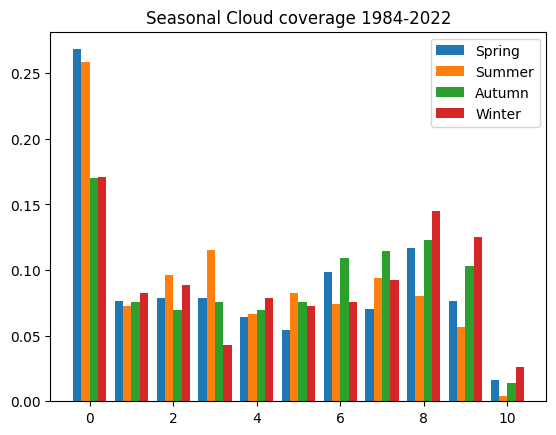

In [113]:
ax = plt.subplot(111)
plt.title(f"Seasonal Cloud coverage 1984-2022")
x = np.asarray(list(range(len(seasons[0]))))

width = 0.2
ax.bar(x-1.5*width, seasons[0],  width=width, label="Spring")
ax.bar(x-0.5*width, seasons[1], width=width, label="Summer")
ax.bar(x+0.5*width, seasons[2], width=width, label="Autumn")
ax.bar(x+1.5*width, seasons[3],  width=width, label="Winter")
plt.legend()
plt.show()